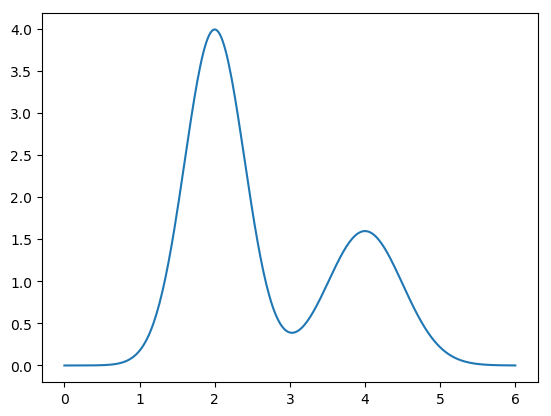

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x19ca78240>

In [1]:
using PyCall
include("../src/gauss_error.jl")
include("../src/kernels.jl")

a = 0.
b = 6.

function phi(x::Float64)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5

    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

x = collect(range(a, stop=b, length=300))

using PyPlot
myplot = plot(x, phi.(x))

In [2]:
kernel_name = "triangular"

function kernel(x::Float64, y::Float64)
    return getOpticsKernels(kernel_name)(x, y)
end

kernel (generic function with 1 method)

Any[

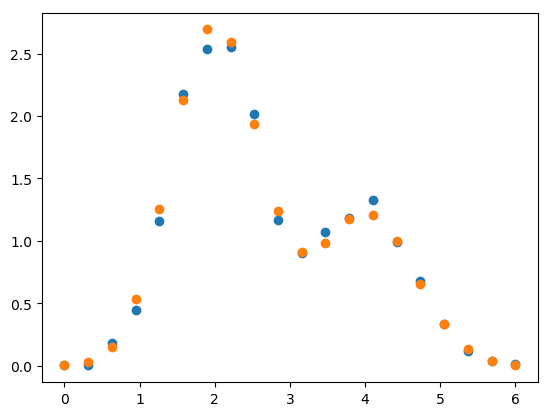

0.00704523, -0.0222191, 0.0309847, -0.0843536, -0.0957015, 0.0468631, -0.152742, -0.0346762, 0.08195, -0.0703137, -0.00672989, 0.0917693, 0.00954735, 0.125027, -0.00339265, 0.0268915, -0.000606658, -0.0114445, 0.00193578, 0.00498634]


In [3]:
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]
y = collect(range(a, stop=b, length=20))
ftrue = convolution.(y)
sig = 0.05*ftrue + [0.01 for i = 1:Base.length(ftrue)]
using Compat, Random, Distributions
noise = []
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end
f = ftrue + noise
plot(y, f, "o")
plot(y, ftrue, "o")
println(noise)

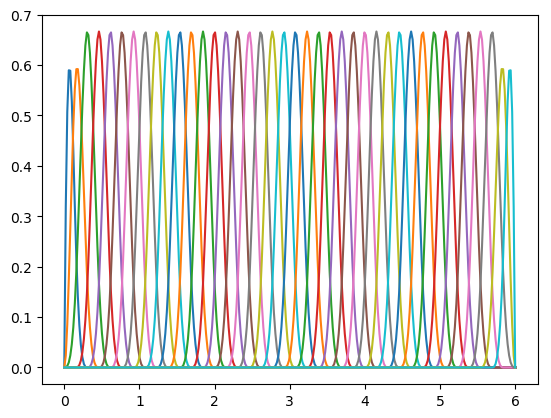

40


In [4]:
knots = collect(range(a, b, length=40))
basis = CubicSplineBasis(knots, ("dirichlet", "dirichlet"))
for basis_function in basis.basis_functions
    plot(x, basis_function.f.(x))
end
println(length(basis))

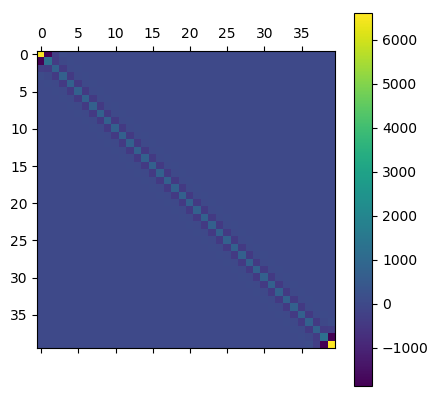

40

PyObject <matplotlib.colorbar.Colorbar object at 0x19cd1c7b8>

In [5]:
print(length(basis))
my_omega = omega(basis, 2)[1]
# for i = 1:size(my_omega)[1]
#     for j = 1:size(my_omega)[1]
#         my_omega[i, j] = abs(my_omega[i, j])
#     end
# end
matshow(my_omega)
colorbar()

In [6]:
model = GaussErrorUnfolder(basis, omega(basis, 2))
println()

In [7]:
phi_reconstruct = solve(model, kernel, f, sig, y)

Iter     Function value   Gradient norm 
     0    -2.746758e+02     8.357322e+00
     1    -2.860426e+02     3.287998e+00
     2    -2.877674e+02     6.778237e-03
     3    -2.877674e+02     8.745010e-09


Dict{String,Array{Float64,N} where N} with 3 entries:
  "errors" => [0.00533914 0.0101668 … 4.09154e-6 1.3521e-6; 0.0101668 0.0334616…
  "alphas" => [0.0683187]
  "coeff"  => [-0.0153809, -0.0470627, -0.100842, -0.138469, -0.122623, -0.0139…

In [11]:
phivec = PhiVec(phi_reconstruct["coeff"], basis, phi_reconstruct["errors"])
println()

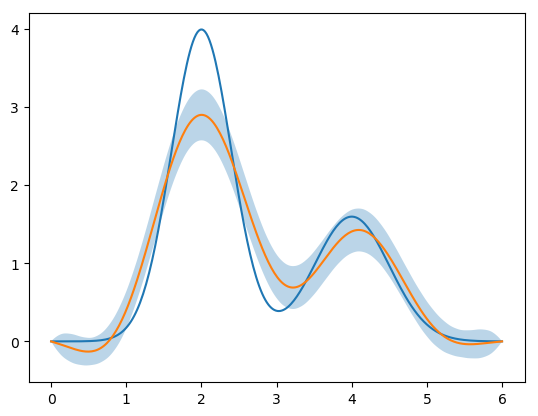

PyObject <matplotlib.collections.PolyCollection object at 0x19d1f0d30>

In [12]:
using PyPlot

plot(x, phi.(x))
# title(kernel_name + "kernel")
phi_reconstructed = call(phivec, x)
phi_reconstructed_errors = errors(phivec, x)

plot(x, phi_reconstructed)
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3)

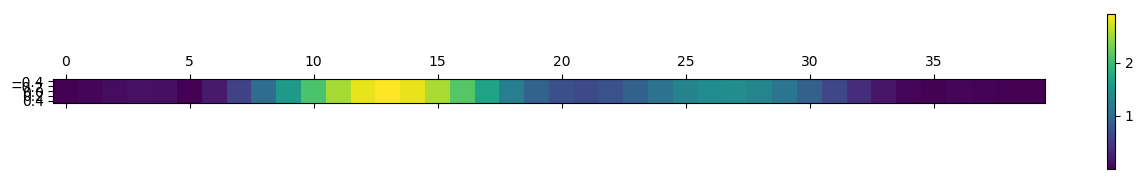

PyObject <matplotlib.colorbar.Colorbar object at 0x19ef19550>

In [13]:
matshow(reshape(map(x->abs(x), phi_reconstruct["coeff"]), (1, length(basis))))
colorbar()